--- Loading Prepared Sequence Data ---
Data loaded successfully. X shape: (70000, 56, 10), y shape: (70000,)
--- Reshaping Data for LightGBM ---
Reshaped X to: (70000, 560)
--- Splitting Data ---
--- Calculating Class Weights for LightGBM ---
Scale Pos Weight: 165.67

--- Building and Training LightGBM Model ---
[LightGBM] [Info] Number of positive: 336, number of negative: 55664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.900617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114828
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 560
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006000 -> initscore=-5.109978
[LightGBM] [Info] Start training from score -5.109978
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[225]	valid_0's binary_logloss: 0.0238677

--- Evaluating Model Performance ---

Classification

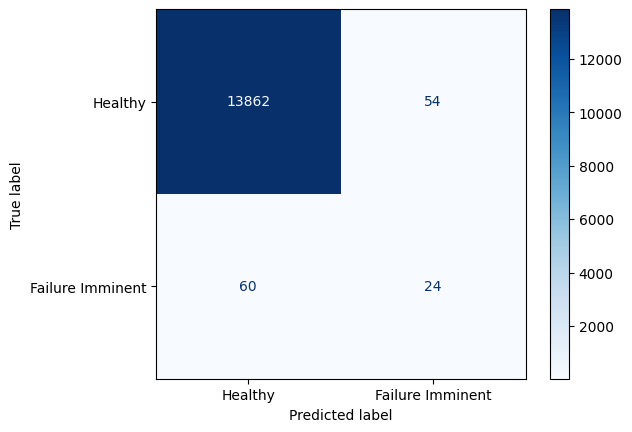


✅ Training complete. Final LightGBM model saved to 'prediction_model_lgbm_final.joblib'.


In [8]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import warnings
import os

warnings.filterwarnings("ignore")

# --- 1. Load Data ---
print("--- Loading Prepared Sequence Data ---")
X_FILE = 'sequences_large.npy'
Y_FILE = 'labels_if_large.npy'

try:
    X = np.load(X_FILE)
    y = np.load(Y_FILE)
    print(f"Data loaded successfully. X shape: {X.shape}, y shape: {y.shape}")
except FileNotFoundError:
    print(f"Error: Make sure '{X_FILE}' and '{Y_FILE}' exist.")
    exit()

# --- 2. Reshape Data for LightGBM ---
# LightGBM expects a 2D array (samples, features), so we flatten the sequences.
print("--- Reshaping Data for LightGBM ---")
n_samples = X.shape[0]
n_timesteps = X.shape[1]
n_features = X.shape[2]
X_reshaped = X.reshape(n_samples, n_timesteps * n_features)
print(f"Reshaped X to: {X_reshaped.shape}")

# --- 3. Split Data ---
print("--- Splitting Data ---")
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. Handle Class Imbalance ---
# LightGBM has a built-in parameter for this, which is more stable.
print("--- Calculating Class Weights for LightGBM ---")
count_healthy = np.sum(y_train == 0)
count_failing = np.sum(y_train == 1)
scale_pos_weight = count_healthy / count_failing
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

# --- 5. Build and Train the LightGBM Model ---
print("\n--- Building and Training LightGBM Model ---")
lgbm = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=1000, # Train a good number of trees
    learning_rate=0.05,
    num_leaves=31,
    scale_pos_weight=scale_pos_weight, # Handle imbalance
    random_state=42,
    n_jobs=-1
)

# Train the model with early stopping
lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(10)] # Stop if performance doesn't improve for 10 rounds
)

# --- 6. Evaluate the Model ---
print("\n--- Evaluating Model Performance ---")
y_pred = lgbm.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Failure Imminent']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Failure Imminent'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# --- 7. Save the Final Model ---
MODEL_FILENAME = 'prediction_model_lgbm_final.joblib'
joblib.dump(lgbm, MODEL_FILENAME)
print(f"\n✅ Training complete. Final LightGBM model saved to '{MODEL_FILENAME}'.")

--- Loading data and trained LightGBM model ---
--- Getting raw prediction scores from the model ---
--- Plotting the Precision-Recall Trade-off Curve ---


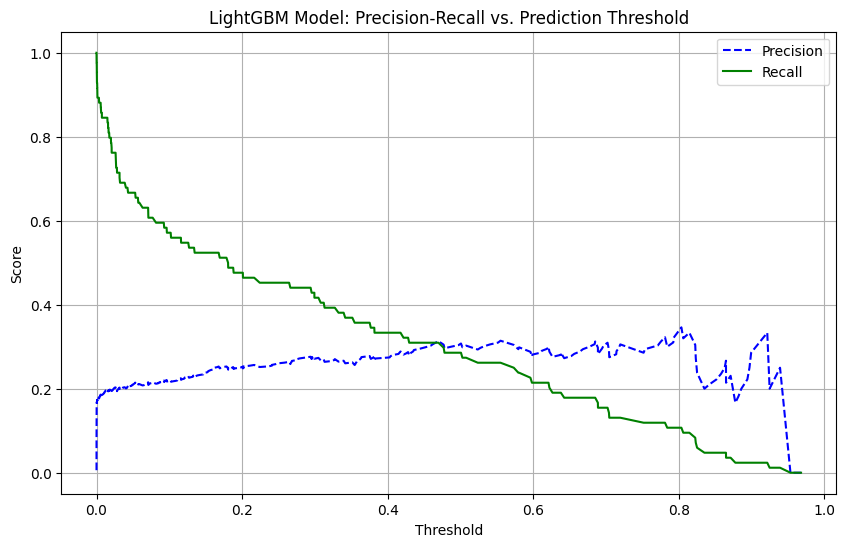


--- Finding and Applying a Better Threshold ---
Original Report (Threshold = 0.50):
                  precision    recall  f1-score   support

         Healthy       1.00      1.00      1.00     13916
Failure Imminent       0.31      0.29      0.30        84

        accuracy                           0.99     14000
       macro avg       0.65      0.64      0.65     14000
    weighted avg       0.99      0.99      0.99     14000

A better threshold might be: 0.0149
This threshold aims for at least 80% Recall while maximizing Precision.

New Report using Tuned Threshold (0.0149):
                  precision    recall  f1-score   support

         Healthy       1.00      0.98      0.99     13916
Failure Imminent       0.20      0.83      0.32        84

        accuracy                           0.98     14000
       macro avg       0.60      0.91      0.65     14000
    weighted avg       0.99      0.98      0.99     14000



In [9]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import joblib

# --- 1. Load Data and Model ---
print("--- Loading data and trained LightGBM model ---")
try:
    X = np.load('sequences_large.npy')
    y = np.load('labels_if_large.npy')
    model = joblib.load('prediction_model_lgbm_final.joblib')
except FileNotFoundError:
    print("Error: Make sure all necessary files are available.")
    exit()

# Reshape data for the model
n_samples, n_timesteps, n_features = X.shape
X_reshaped = X.reshape(n_samples, n_timesteps * n_features)

# Recreate the exact test set
_, X_test, _, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. Get Prediction Probabilities ---
print("--- Getting raw prediction scores from the model ---")
# Get the probability scores for the 'Failure Imminent' class
y_scores = model.predict_proba(X_test)[:, 1]

# --- 3. Calculate and Plot the Precision-Recall Curve ---
print("--- Plotting the Precision-Recall Trade-off Curve ---")
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.title('LightGBM Model: Precision-Recall vs. Prediction Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# --- 4. Find and Apply a Better Threshold ---
print("\n--- Finding and Applying a Better Threshold ---")

# Let's find a threshold that gives us at least 80% recall
try:
    high_recall_indices = np.where(recall[:-1] >= 0.80)[0]
    # From those options, find the one with the best precision
    best_threshold_idx = high_recall_indices[np.argmax(precision[high_recall_indices])]
    best_threshold = thresholds[best_threshold_idx]

    print(f"Original Report (Threshold = 0.50):")
    y_pred_default = (y_scores > 0.5).astype("int32")
    print(classification_report(y_test, y_pred_default, target_names=['Healthy', 'Failure Imminent']))

    print("="*60)
    print(f"A better threshold might be: {best_threshold:.4f}")
    print(f"This threshold aims for at least 80% Recall while maximizing Precision.")
    print(f"\nNew Report using Tuned Threshold ({best_threshold:.4f}):")
    y_pred_tuned = (y_scores > best_threshold).astype("int32")
    print(classification_report(y_test, y_pred_tuned, target_names=['Healthy', 'Failure Imminent']))

except ValueError:
    print("\nCould not automatically find a threshold for 80% recall. Please inspect the plot manually to choose one.")

In [10]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error
import joblib

# --- 1. Load Data ---
print("--- Loading Prepared Sequence Data for Diagnostician ---")
X = np.load('sequences_large.npy')
y_why = np.load('labels_why_large.npy')
y_when = np.load('labels_when_large.npy')

# --- 2. Isolate ONLY the Failing Data ---
print("--- Isolating Data for Failing Devices Only ---")
failure_indices = np.where(y_why != 0)[0]

X_failing = X[failure_indices]
y_why_failing = y_why[failure_indices]
y_when_failing = y_when[failure_indices]

print(f"Isolated {len(X_failing)} sequences from failing devices.")

# --- 3. Reshape Data for LightGBM ---
n_samples, n_timesteps, n_features = X_failing.shape
X_reshaped = X_failing.reshape(n_samples, n_timesteps * n_features)

# --- 4. Split Data ---
X_train, X_test, y_train_why, y_test_why, y_train_when, y_test_when = train_test_split(
    X_reshaped, y_why_failing, y_when_failing, test_size=0.2, random_state=42
)

# --- 5. Train the "WHY" (Classifier) Model ---
print("\n--- Training the 'WHY' (Classifier) Model ---")
lgbm_why = lgb.LGBMClassifier(objective='multiclass', random_state=42)
lgbm_why.fit(X_train, y_train_why)

# --- 6. Train the "WHEN" (Regressor) Model ---
print("\n--- Training the 'WHEN' (Regressor) Model ---")
lgbm_when = lgb.LGBMRegressor(objective='regression_l1', random_state=42) # L1 is robust
lgbm_when.fit(X_train, y_train_when)

# --- 7. Evaluate the Models ---
print("\n--- Evaluating Diagnostician Models ---")

# Evaluate "WHY" model
y_pred_why = lgbm_why.predict(X_test)
print("\n'WHY' Model Classification Report:")
print(classification_report(y_test_why, y_pred_why))

# Evaluate "WHEN" model
y_pred_when = lgbm_when.predict(X_test)
mae = mean_absolute_error(y_test_when, y_pred_when)
print(f"\n'WHEN' Model Mean Absolute Error: {mae:.2f} days")
print("(This means on average, the prediction for days-to-failure is off by this amount)")

# --- 8. Save the Final Models ---
joblib.dump(lgbm_why, 'diagnostician_why_model.joblib')
joblib.dump(lgbm_when, 'diagnostician_when_model.joblib')
print("\n✅ Training complete. Final diagnostician models saved.")

--- Loading Prepared Sequence Data for Diagnostician ---
--- Isolating Data for Failing Devices Only ---
Isolated 4365 sequences from failing devices.

--- Training the 'WHY' (Classifier) Model ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114796
[LightGBM] [Info] Number of data points in the train set: 3492, number of used features: 560
[LightGBM] [Info] Start training from score -1.092617
[LightGBM] [Info] Start training from score -1.087506
[LightGBM] [Info] Start training from score -1.115944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

--- Training the 'WHEN' (Regressor) Model ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114796
[LightGBM] [Info] Number of d